In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings, tiktoken
from datetime import datetime, timezone
from keys import config

from langchain.llms import Ollama
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain import PromptTemplate, LLMChain

from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

warnings.filterwarnings("ignore")

# **Load dataset**

In [2]:
df = pd.read_excel("../data/tableElastic.xlsx", engine='openpyxl')
df.head()

,Name,IP,Date,Memory Min,Memory Max,Memory Avg,Disk Min,Disk Max,Disk Avg,CPU Min,CPU Max,CPU Avg,GPU Min,GPU Max,GPU Avg
0,vbogdtlobsvp02,172.30.5.132,2025-01-07T14:17:57.000Z,0.0,19.729494,9.541167,0,0,0,0.0,16.382360,4.221615,0,0,0
1,vbogevoprxp01,172.30.5.241,2025-01-07T14:17:56.000Z,0.0,34.577225,14.523084,0,0,0,0.0,19.297779,3.753499,0,0,0
2,collector,172.30.5.246,2025-01-07T14:17:53.000Z,0.0,33.836704,15.296433,0,0,0,0.0,38.552620,7.427592,0,0,0
3,vbogdtlobsvp01,172.30.5.131,2025-01-07T14:17:50.000Z,0.0,32.901337,16.013852,0,0,0,0.0,34.544769,3.372553,0,0,0
4,vbogdtlobsvp03,172.30.5.133,2025-01-07T14:17:47.000Z,0.0,17.728832,8.394328,0,0,0,0.0,9.947598,1.010941,0,0,0


In [3]:
df.columns

Index(['Name', 'IP', 'Date', 'Memory Min', 'Memory Max', 'Memory Avg',
       'Disk Min', 'Disk Max', 'Disk Avg', 'CPU Min', 'CPU Max', 'CPU Avg',
       'GPU Min', 'GPU Max', 'GPU Avg'],
      dtype='object')

In [4]:
df.head()

,Name,IP,Date,Memory Min,Memory Max,Memory Avg,Disk Min,Disk Max,Disk Avg,CPU Min,CPU Max,CPU Avg,GPU Min,GPU Max,GPU Avg
0,vbogdtlobsvp02,172.30.5.132,2025-01-07T14:17:57.000Z,0.0,19.729494,9.541167,0,0,0,0.0,16.382360,4.221615,0,0,0
1,vbogevoprxp01,172.30.5.241,2025-01-07T14:17:56.000Z,0.0,34.577225,14.523084,0,0,0,0.0,19.297779,3.753499,0,0,0
2,collector,172.30.5.246,2025-01-07T14:17:53.000Z,0.0,33.836704,15.296433,0,0,0,0.0,38.552620,7.427592,0,0,0
3,vbogdtlobsvp01,172.30.5.131,2025-01-07T14:17:50.000Z,0.0,32.901337,16.013852,0,0,0,0.0,34.544769,3.372553,0,0,0
4,vbogdtlobsvp03,172.30.5.133,2025-01-07T14:17:47.000Z,0.0,17.728832,8.394328,0,0,0,0.0,9.947598,1.010941,0,0,0


# **Load LLM model**

In [5]:
LLM_Llama  = Ollama(model="llama3.2:1b")
LLM_OpenAI = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=None, timeout=None, max_retries=2, api_key=config.api_key)

In [6]:
agent = create_pandas_dataframe_agent(llm=LLM_OpenAI, df=df, agent_type="openai-tools",verbose=True, allow_dangerous_code=True)

# **Pruebas**

In [7]:
response = agent.invoke("Dame una descripción de la tabla con media y varianza por los 5 host de mayor consumo de CPU")



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df.groupby('Name')[['CPU Avg']].mean().nlargest(5, 'CPU Avg')"}`


                  CPU Avg
Name                     
vbogdtlobsvp08  23.387892
Zabbix server   23.345293
vbogevokesl03   16.569246
vbogmosmonp02   14.979116
vbogevokesl02   13.111357
Invoking: `python_repl_ast` with `{'query': "df[df['Name'].isin(['vbogdtlobsvp08', 'Zabbix server', 'vbogevokesl03', 'vbogmosmonp02', 'vbogevokesl02'])][['CPU Avg']].var()"}`


CPU Avg    23.071282
dtype: float64
Invoking: `python_repl_ast` with `{'query': "df[df['Name'].isin(['vbogdtlobsvp08', 'Zabbix server', 'vbogevokesl03', 'vbogmosmonp02', 'vbogevokesl02'])][['CPU Avg']].mean()"}`


CPU Avg    18.278581
dtype: float64Los 5 hosts de mayor consumo de CPU son:

1. vbogdtlobsvp08
2. Zabbix server
3. vbogevokesl03
4. vbogmosmonp02
5. vbogevokesl02

Para estos hosts, la media de consumo de CPU es de aproximadamente 18.28 y la varianza es de aproximadamente 2

In [8]:
response['output']

'Los 5 hosts de mayor consumo de CPU son:\n\n1. vbogdtlobsvp08\n2. Zabbix server\n3. vbogevokesl03\n4. vbogmosmonp02\n5. vbogevokesl02\n\nPara estos hosts, la media de consumo de CPU es de aproximadamente 18.28 y la varianza es de aproximadamente 23.07.'

# **Prompt**

In [33]:
TEMPLATE = """ Eres un asistente avanzado especializado en el análisis de datos tabulares. Tu misión es ayudar a los compañeros de trabajo a mejorar su experiencia y ayudarles.
Los datos y/o métricas que contiene la tabla corresponde a información de:

- Name: Nombre del host.
- IP: Dirección IP del host.
- Date: Fecha de la medición del evento.
- Memory Min: valor minimo de consumo de memoria RAM en un periodo de 1 hora.
- Memory Max: valor máximo de consumo de memoria RAM en un periodo de 1 hora.
- Memory Avg: valor promedio de consumo de memoria RAM en un periodo de 1 hora.
- Disk Min: valor minimo de consumo de disco duro en un periodo de 1 hora. 
- Disk Max: valor máximo de consumo de disco duro en un periodo de 1 hora. 
- Disk Avg: valor promedio de consumo de disco duro en un periodo de 1 hora.  
- CPU Min: valor minimo de consumo de CPU en un periodo de 1 hora. 
- CPU Max: valor máximo de consumo de CPU en un periodo de 1 hora. 
- CPU Avg: valor promedio de consumo de CPU en un periodo de 1 hora. 
- GPU Min: valor minimo de consumo de GPU en un periodo de 1 hora. 
- GPU Max: valor máximo de consumo de GPU en un periodo de 1 hora. 
- GPU Avg: valor promedio de consumo de GPU en un periodo de 1 hora. 

Tu tarea principal es interpretar preguntas y responder UNICAMENTE EN IDIOMA ESPAÑOL

"""

In [34]:
model_name = "gpt-3.5-turbo"
encoding = tiktoken.encoding_for_model(model_name)

In [35]:
token_count = len(encoding.encode(TEMPLATE))
print(token_count)

347


# **ChatBot**

In [36]:
agent = create_pandas_dataframe_agent(
    llm=LLM_OpenAI, 
    df=df, 
    prompt_template=TEMPLATE,
    agent_type="openai-tools",
    verbose=True, 
    allow_dangerous_code=True,
    language="es"
    )



In [37]:
question = "Dame una descripción de la tabla con media y varianza por los 5 host de mayor consumo de CPU"

response = agent.invoke(question)



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df.groupby('Name').agg({'CPU Avg': ['mean', 'var']}).nlargest(5, ('CPU Avg', 'mean'))"}`


                  CPU Avg    
                     mean var
Name                         
vbogdtlobsvp08  23.387892 NaN
Zabbix server   23.345293 NaN
vbogevokesl03   16.569246 NaN
vbogmosmonp02   14.979116 NaN
vbogevokesl02   13.111357 NaNLos 5 hosts con mayor consumo promedio de CPU son:

1. vbogdtlobsvp08 con una media de 23.39 y varianza no disponible.
2. Zabbix server con una media de 23.35 y varianza no disponible.
3. vbogevokesl03 con una media de 16.57 y varianza no disponible.
4. vbogmosmonp02 con una media de 14.98 y varianza no disponible.
5. vbogevokesl02 con una media de 13.11 y varianza no disponible.

> Finished chain.


In [39]:
response['output']

'Los 5 hosts con mayor consumo promedio de CPU son:\n\n1. vbogdtlobsvp08 con una media de 23.39 y varianza no disponible.\n2. Zabbix server con una media de 23.35 y varianza no disponible.\n3. vbogevokesl03 con una media de 16.57 y varianza no disponible.\n4. vbogmosmonp02 con una media de 14.98 y varianza no disponible.\n5. vbogevokesl02 con una media de 13.11 y varianza no disponible.'



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\n\n# Get the top 5 hosts with the highest memory max consumption\ntop_hosts = df.nlargest(5, 'Memory Max')\n\n# Create a bar plot\nplt.figure(figsize=(12, 6))\nplt.bar(top_hosts['Name'], top_hosts['Memory Max'], color='skyblue')\nplt.xlabel('Hosts')\nplt.ylabel('Memory Max Consumption')\nplt.title('Top 5 Hosts with Highest Memory Max Consumption')\nplt.xticks(rotation=45)\nplt.show()"}`




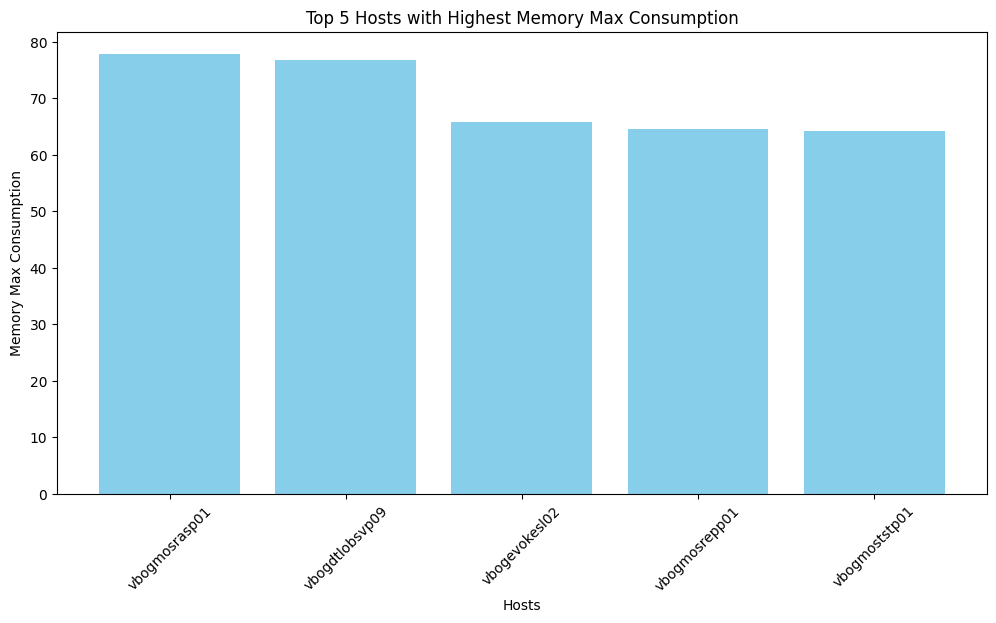

Aquí tienes el gráfico de barras que muestra los 5 hosts con el mayor consumo de memoria máxima. Cada barra representa el consumo de memoria máxima para un host específico.

> Finished chain.


{'input': 'Dame un grafico de barras para los 5 host de mayor consumo',
 'output': 'Aquí tienes el gráfico de barras que muestra los 5 hosts con el mayor consumo de memoria máxima. Cada barra representa el consumo de memoria máxima para un host específico.'}

In [15]:
#agent.invoke("Dame una grafico de serie de tiempo con el consumo de memoria de vbogdtlobsvp09 en el tiempo")
agent.invoke("Dame un grafico de barras para los 5 host de mayor consumo")

In [16]:
questions = [
    "¿Qué información tienes?",
    "¿Qué datos conoces?",
    "¿Qué métricas tienes?",
    "¿Cuál es el servidor con mayor consumo de recursos?",
    "¿Por qué el servidor X tiene un consumo de recursos elevado?",
    "¿En qué momento se presentan picos de recursos y por qué?",
    "¿Qué proceso tiene mayor consumo de recursos?",
    "¿Cuál es el capacity planning para el servidor X?",
    "Construye un capacity planning de la infraestructura",
    "¿Qué anomalías has detectado?"
]


In [18]:
answer = []
for question in questions:
    response = agent.invoke(question)
    answer.append(response['output'])



> Entering new AgentExecutor chain...
Tengo un dataframe de pandas llamado `df` que contiene información sobre diferentes servidores. La información incluye el nombre del servidor, la dirección IP, la fecha, y varias métricas como la memoria mínima, máxima y promedio, el disco mínimo, máximo y promedio, el CPU mínimo, máximo y promedio, y el GPU mínimo, máximo y promedio.

> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': 'df.columns'}`


Index(['Name', 'IP', 'Date', 'Memory Min', 'Memory Max', 'Memory Avg',
       'Disk Min', 'Disk Max', 'Disk Avg', 'CPU Min', 'CPU Max', 'CPU Avg',
       'GPU Min', 'GPU Max', 'GPU Avg', 'Total Resources'],
      dtype='object')Los datos que conozco en el dataframe son los siguientes:

1. Name
2. IP
3. Date
4. Memory Min
5. Memory Max
6. Memory Avg
7. Disk Min
8. Disk Max
9. Disk Avg
10. CPU Min
11. CPU Max
12. CPU Avg
13. GPU Min
14. GPU Max
15. GPU Avg
16. Total Resources

> Finished chain.


> 

In [19]:
answer

['Tengo un dataframe de pandas llamado `df` que contiene información sobre diferentes servidores. La información incluye el nombre del servidor, la dirección IP, la fecha, y varias métricas como la memoria mínima, máxima y promedio, el disco mínimo, máximo y promedio, el CPU mínimo, máximo y promedio, y el GPU mínimo, máximo y promedio.',
 'Los datos que conozco en el dataframe son los siguientes:\n\n1. Name\n2. IP\n3. Date\n4. Memory Min\n5. Memory Max\n6. Memory Avg\n7. Disk Min\n8. Disk Max\n9. Disk Avg\n10. CPU Min\n11. CPU Max\n12. CPU Avg\n13. GPU Min\n14. GPU Max\n15. GPU Avg\n16. Total Resources',
 'Las métricas disponibles en el dataframe son las siguientes:\n- Memory Min\n- Memory Max\n- Memory Avg\n- Disk Min\n- Disk Max\n- Disk Avg\n- CPU Min\n- CPU Max\n- CPU Avg\n- GPU Min\n- GPU Max\n- GPU Avg',
 'El servidor con el mayor consumo de recursos es `vbogevokesl03`.',
 'Los valores promedio de consumo de recursos para todos los servidores en el dataframe son los siguientes:\n

# **Advaced prompt**

In [47]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", TEMPLATE),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
    ]
)




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\nimport numpy as np\n\nx = np.linspace(0, 10, 100)\ny = np.sin(x)\n\nplt.figure()\nplt.plot(x, y)\nplt.title('Gráfico de la función seno')\nplt.xlabel('x')\nplt.ylabel('sin(x)')\nplt.show()"}`




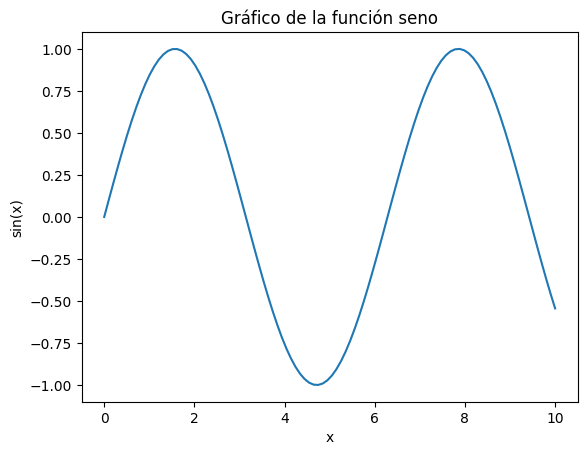

Aquí tienes un gráfico de la función seno generado mediante Python.

> Finished chain.


'Aquí tienes un gráfico de la función seno generado mediante Python.'

In [52]:
question = "Puedes dibujar alguna cosa mediante Python?"
response = agent.invoke({"input": question})

response['output']